In [ ]:
中文车牌识别

In [1]:
import cv2
import time
import numpy as np
from PIL import ImageFont
from PIL import Image
from PIL import ImageDraw
import json
import matplotlib.pyplot as plt
import sys

In [2]:
image = cv2.imread("plate.jpg")

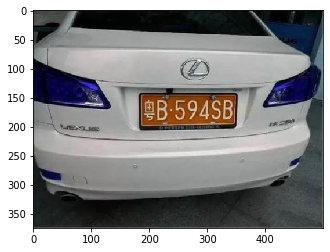

In [3]:
plt.imshow(image)

In [4]:
image.shape

(375, 500, 3)

In [5]:
watch_cascade = cv2.CascadeClassifier('./model/cascade.xml')

In [ ]:
opencv_traincascade -data data \  # 模型xml文件保存的目录
                    -vec face.vec \   # 数据集文件
                    -numPos 4200 \  # 正例图片数
                    -numNeg 32000 \  # 负例图片数
                    -numStages 5 \   # stage数越多，训练效果越好，但是耗时也越长
                    -numThreads 6 \
                    -featureType LBP \  #特征
                    -w 112 \
                    -h 112 \

In [63]:
def computeSafeRegion(shape,bounding_rect):
    top = bounding_rect[1] # y
    bottom  = bounding_rect[1] + bounding_rect[3] # y +  h
    left = bounding_rect[0] # x
    right =   bounding_rect[0] + bounding_rect[2] # x +  w

    min_top = 0
    max_bottom = shape[0]
    min_left = 0
    max_right = shape[1]

    # print "computeSateRegion input shape",shape
    if top < min_top:
        top = min_top
        # print "tap top 0"
    if left < min_left:
        left = min_left
        # print "tap left 0"

    if bottom > max_bottom:
        bottom = max_bottom
        #print "tap max_bottom max"
    if right > max_right:
        right = max_right
        #print "tap max_right max"

    # print "corr",left,top,right,bottom
    return [left,top,right-left,bottom-top]


def cropped_from_image(image,rect):
    x, y, w, h = computeSafeRegion(image.shape,rect)
    return image[y:y+h,x:x+w]

def detectPlateRough(image_gray,resize_h = 720,en_scale =1.08 ,top_bottom_padding_rate = 0.05):
    print(image_gray.shape)

    if top_bottom_padding_rate>0.2:
        print("error:top_bottom_padding_rate > 0.2:",top_bottom_padding_rate)
        exit(1)

    height = image_gray.shape[0]
    padding =    int(height*top_bottom_padding_rate)
    scale = image_gray.shape[1]/float(image_gray.shape[0])

    image = cv2.resize(image_gray, (int(scale*resize_h), resize_h))

    image_color_cropped = image[padding:resize_h-padding,0:image_gray.shape[1]]

    image_gray = cv2.cvtColor(image_color_cropped,cv2.COLOR_RGB2GRAY)

    watches = watch_cascade.detectMultiScale(image_gray, en_scale, 2, minSize=(36, 9),maxSize=(36*40, 9*40))
    print(watches)
    cropped_images = []
    for (x, y, w, h) in watches:
        cropped_origin = cropped_from_image(image_color_cropped, (int(x), int(y), int(w), int(h)))
        plt.imshow(cropped_origin)
        plt.show()
        x -= w * 0.14
        w += w * 0.28
        y -= h * 0.6
        h += h * 1.1;

        cropped = cropped_from_image(image_color_cropped, (int(x), int(y), int(w), int(h)))
        plt.imshow(cropped)
        plt.show()
        cropped_images.append([cropped,[x, y+padding, w, h],cropped_origin])
    return cropped_images

(375, 500, 3)
[[193 113 162  41]]


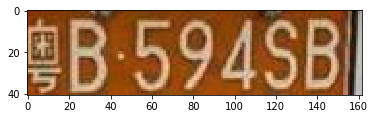

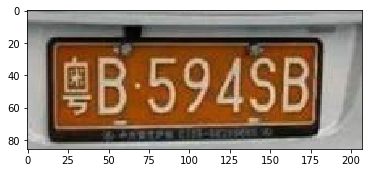

1
3
86
207


In [64]:
plates = detectPlateRough(image,image.shape[0],top_bottom_padding_rate=0.1)
print(len(plates))
print(len(plates[0]))
print(len(plates[0][0]))
print(len(plates[0][0][0]))

In [23]:
chars = ["京", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "皖", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂",
             "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "A",
             "B", "C", "D", "E", "F", "G", "H", "J", "K", "L", "M", "N", "P", "Q", "R", "S", "T", "U", "V", "W", "X",
             "Y", "Z","港","学","使","警","澳","挂","军","北","南","广","沈","兰","成","济","海","民","航","空"
             ];
注意，没有O和I 0,1

In [24]:
len(chars)

83

In [44]:
from keras import backend as K
from keras.models import *
from keras.layers import *

def construct_model(model_path):
    input_tensor = Input((None, 40, 3))
    x = input_tensor
    base_conv = 32

    for i in range(3):
        x = Conv2D(base_conv * (2 ** (i)), (3, 3),padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
    40->5
    x = Conv2D(256, (5, 5))(x)
    5->1
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(1024, (1, 1))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    #
    x = Conv2D(len(chars)+1, (1, 1))(x)
    x = Activation('softmax')(x)
    base_model = Model(inputs=input_tensor, outputs=x)
    base_model.load_weights(model_path)
    return base_model

In [45]:
pred_model = construct_model("./model/ocr_plate_all_w_rnn_2.h5")

In [52]:
def fastdecode(y_pred):
    results = ""
    confidence = 0.0
    table_pred = y_pred.reshape(-1, len(chars)+1)
    
    res = table_pred.argmax(axis=1)
    print(res)
    
    for i,one in enumerate(res):
        if one<len(chars) and (i==0 or (one!=res[i-1])):
            results+= chars[one]
            confidence+=table_pred[i][one]
    confidence/= len(results)
    return results,confidence

def recognizeOne(src):
    x_tempx = src
    x_temp = cv2.resize(x_tempx,( 160,40))
    x_temp = x_temp.transpose(1, 0, 2)
    t0 = time.time()
    y_pred = pred_model.predict(np.array([x_temp]))
    print(y_pred.shape)
    return fastdecode(y_pred)

In [53]:
plate,rect,origin_plate = plates[0]
res, confidence = recognizeOne(origin_plate)
print("res",res)

(1, 16, 1, 84)
[83 83 19 42 83 36 83 40 83 83 35 83 57 83 83 42]
res 粤B594SB


In [ ]:
模型效果

In [ ]:
准确率
车牌检测：精确率+召回率->PR曲线

0.6432192807192807


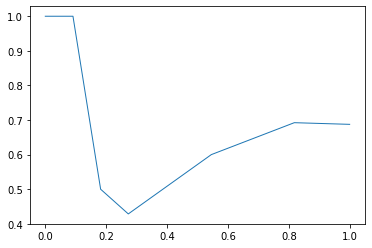

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,auc,precision_recall_curve

y=[0,0,0,0,0,1,1,1,0,1,1,1,0,0,1,1,1,0,1,1]
pred=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.5,0.6,0.7,0.8,0.9,0.5,0.6,0.7,0.8,0.9,1.0]

precision,recall,thresholds = precision_recall_curve(y,pred)
plt.plot(recall,precision,lw=1)
area = auc(recall, precision)
print(area)

0.6432192807192807


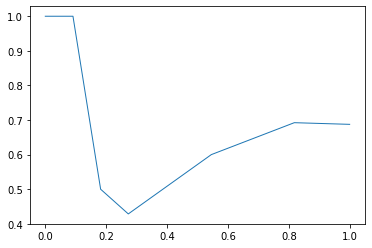

In [62]:
y=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,1,1,0,0,1,1,1,0,1,1]
pred=[0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.5,0.6,0.7,0.8,0.9,0.5,0.6,0.7,0.8,0.9,1.0]

precision,recall,thresholds = precision_recall_curve(y,pred)
plt.plot(recall,precision,lw=1)
area = auc(recall, precision)
print(area)

In [ ]:
#实际数据
groudtruths
#检测到的车牌
plates
threshold = 0.5
y=[]
for plate in plates:
    IOU = computeIOU(plate,groudtruths)
    if IOU>threshold:
        y.append(1)
    else:
        y.append(0)


In [ ]:
测试集1000张
AUC：0.95
字符准确率：0.99

In [69]:
#速度
import time

def computeSafeRegion(shape,bounding_rect):
    top = bounding_rect[1] # y
    bottom  = bounding_rect[1] + bounding_rect[3] # y +  h
    left = bounding_rect[0] # x
    right =   bounding_rect[0] + bounding_rect[2] # x +  w

    min_top = 0
    max_bottom = shape[0]
    min_left = 0
    max_right = shape[1]

    # print "computeSateRegion input shape",shape
    if top < min_top:
        top = min_top
        # print "tap top 0"
    if left < min_left:
        left = min_left
        # print "tap left 0"

    if bottom > max_bottom:
        bottom = max_bottom
        #print "tap max_bottom max"
    if right > max_right:
        right = max_right
        #print "tap max_right max"

    # print "corr",left,top,right,bottom
    return [left,top,right-left,bottom-top]


def cropped_from_image(image,rect):
    x, y, w, h = computeSafeRegion(image.shape,rect)
    return image[y:y+h,x:x+w]

def detectPlateRough(image_gray,resize_h = 720,en_scale =1.08 ,top_bottom_padding_rate = 0.05):
    #print(image_gray.shape)

    if top_bottom_padding_rate>0.2:
        print("error:top_bottom_padding_rate > 0.2:",top_bottom_padding_rate)
        exit(1)

    height = image_gray.shape[0]
    padding =    int(height*top_bottom_padding_rate)
    scale = image_gray.shape[1]/float(image_gray.shape[0])

    image = cv2.resize(image_gray, (int(scale*resize_h), resize_h))

    image_color_cropped = image[padding:resize_h-padding,0:image_gray.shape[1]]

    image_gray = cv2.cvtColor(image_color_cropped,cv2.COLOR_RGB2GRAY)

    watches = watch_cascade.detectMultiScale(image_gray, en_scale, 2, minSize=(36, 9),maxSize=(36*40, 9*40))
    #print(watches)
    cropped_images = []
    for (x, y, w, h) in watches:
        cropped_origin = cropped_from_image(image_color_cropped, (int(x), int(y), int(w), int(h)))
        #plt.imshow(cropped_origin)
        #plt.show()
        x -= w * 0.14
        w += w * 0.28
        y -= h * 0.6
        h += h * 1.1;

        cropped = cropped_from_image(image_color_cropped, (int(x), int(y), int(w), int(h)))
        #plt.imshow(cropped)
        #plt.show()
        cropped_images.append([cropped,[x, y+padding, w, h],cropped_origin])
    return cropped_images

print(time.time())
plates = detectPlateRough(image,image.shape[0],top_bottom_padding_rate=0.1)
print(time.time())

1587720827.1281018
1587720827.166201


In [70]:
plate,rect,origin_plate = plates[0]
print(time.time())
res, confidence = recognizeOne(origin_plate)
print(time.time())

1587720871.906511
(1, 16, 1, 84)
[83 83 19 42 83 36 83 40 83 83 35 83 57 83 83 42]
1587720871.9244769


In [ ]:
一张图片60ms

In [ ]:
20ms
99%